# COX Proportional Hazards Model for Celiac Disease Autoantibody Outcome  
>
This notebook contains the code for generating supplementary figures 11 and 12.  

For the main analysis, tri-SNP dosage (0, 1 or 2) is fitted along with covariates: sex, having a first degree relative with CD diagnosis, genetic ancestry, HLA type, country, gluten intake and SNPS previously associated with the outcome.

In addition, the extended haplotype DR3-B8 is fitted instead of tri-SNP as a comparison to show the affect of tri-snp is stronger. 

The analyses are repeated using only DR3/DQ2 homozygotes.

This notebook is not heavily commented. Please see the code notebook for supplementary figures 1 and 2 for the comments and detailed explanation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from lifelines import CoxPHFitter
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
lifelines           0.26.3
matplotlib          3.9.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-19 10:12


Import metadata

In [2]:
filtered = pd.read_csv("../data/filtered_meta_final.csv")
filtered.head()

,mp257_maskid,family_id,immunochip_id,sex,Cntry,POP,ancestry,POP_reported,t1d,t1d_diag_age_censor,...,rs61751041 (LAMB1),rs6967298 (AUTS2),rs72704176 (ASH1L),rs72717025 (FCGR2A),rs73043122 (RNASET2/MIR3939),rs77532435 (GRB10),rs8013918 (FOS),rs9934817 (RBFOX1),rs389884,rs926552
0,996512,9000247.0,9000247_996512,Male,SWE,EUR,EUR,NaN,1,135.972,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,474979,474979.0,474979_474979,Male,SWE,EUR,EUR,NaN,0,183.443,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2,581412,581412.0,581412_581412,Male,SWE,EUR,EUR,NaN,0,186.235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,864158,864158.0,864158_864158,Male,SWE,EUR,EUR,EUR,0,167.017,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4,669152,669152.0,669152_669152,Male,SWE,EUR,EUR,NaN,0,174.080,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0


Create ordered hla type list

In [3]:
select_hla = ['DR4/DR8', 'DR3/DR3', 'DR3/DR4',
              'DR4/DR4', "DR1/DR4", "DR4/DR13"]
filtered["hla_type"] = pd.Categorical(filtered["hla_type"], 
               categories=select_hla,
               ordered=True)

Create oredered population list

In [4]:
select_pops = ["EUR", "AMR", "AFR"]
filtered["POP"] = pd.Categorical(
    filtered["POP"],
    categories=select_pops,
    ordered=True)

Create ordered country category

In [5]:
ctry = ["US", "SWE", "FIN", "GER"]
filtered["Country"] = pd.Categorical(
    filtered["Cntry"],
    categories=ctry,
    ordered=True)

Load previous GWAS covariates

In [6]:
snps = pd.read_table("../data/assoc_snps_220824.tsv")
snps.head()

,SNP,Locus,CD_SNP,tTGA_SNP,T1D_SNP,IAA_SNP,SNP_locus
0,rs4851575,"IL18R1, IL18RAP",1,0,0,0,"rs4851575 (IL18R1, IL18RAP)"
1,rs114569351,"PLEK,FBXO48",1,0,0,0,"rs114569351 (PLEK,FBXO48)"
2,rs12493471,"CCR9,LZTFL1,CXCR6",1,0,0,0,"rs12493471 (CCR9,LZTFL1,CXCR6)"
3,rs1054091,"RSPH3,TAGAP",1,0,0,0,"rs1054091 (RSPH3,TAGAP)"
4,rs72704176,ASH1L,1,0,0,0,rs72704176 (ASH1L)


In [7]:
t1d_snps = list(snps.loc[snps["T1D_SNP"] == 1, "SNP_locus"].values)
iaa_snps = list(snps.loc[snps["IAA_SNP"] == 1, "SNP_locus"].values)
tga_snps = list(snps.loc[snps["tTGA_SNP"] == 1, "SNP_locus"].values)
cd_snps = list(snps.loc[snps["CD_SNP"] == 1, "SNP_locus"].values)

## Run coxph model for celiac disease diagnosis

In [8]:
# rename columns to figure-friendly names
filtered.rename(columns={"celiac_fdr": "FDR-CD"}, inplace=True)
filtered.rename(columns={"excess_pre_tga_gluten": "gluten_intake"},
                inplace=True)

In [9]:
assoc = tga_snps
event = "Event = CD Autoantibody"
common_variables = ['sex', 'FDR-CD', 'POP', "hla_type", 
                    "Country", "gluten_intake"] + assoc


common_others = ["Male", 'FDR-CD', "gluten_intake"]

time, outcome = "tga_persist_age_censor", "tga_persist"
outcomes = [time, outcome]

### Fit trisnp
This creates supplementary figure 11.

<lifelines.CoxPHFitter: fitted with 6557 total observations, 5275 right-censored observations>
             duration col = 'tga_persist_age_censor'
                event col = 'tga_persist'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6557
number of events observed = 1282
   partial log-likelihood = -10545.60
         time fit was run = 2025-09-19 14:12:21 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
tri-SNP 101                  0.21       1.23       0.08             0.06             0.36                 1.06                 1.44
FDR-CD                       0.88       2.42       0.09             0.72             1.05                 2.04                 2.87
gluten_intake                0.15       1.16       0.02             0.11             0.19                 1.11                 1.20
rs2409747 (XKR6)             0.19       1.21       0.06             0.08             0.30                 1.08                 1.36
rs12990970 (NPM1P33,CTLA4)  -0.18       0.83       0.04            -0.26            -0.10                 0.77                 0.90
rs11709472 (LPP)            -0.17       0.85       0.04            -0.24            -0.09                 0.78                 0.92
rs72717025 (FCGR2A)          0.37       1.45       0.13             0.12             0.62                 1.12                 1.86
rs114157400 (BANK1)          0.26       1.30       0.10             0.07             0.45                 1.07                 1.57
rs117561283 (IFNG)           0.37       1.45       0.11             0.15             0.60                 1.16                 1.82
rs8013918 (FOS)             -0.12       0.89       0.04            -0.20            -0.04                 0.82                 0.96
Male                        -0.53       0.59       0.06            -0.65            -0.41                 0.52                 0.66
AMR                         -0.45       0.64       0.15            -0.74            -0.16                 0.48                 0.85
AFR                         -1.64       0.19       0.71            -3.02            -0.26                 0.05                 0.77
DR3/DR3                      1.92       6.80       0.20             1.53             2.31                 4.61                10.04
DR3/DR4                      1.19       3.30       0.16             0.88             1.50                 2.41                 4.50
DR4/DR4                      1.11       3.02       0.15             0.81             1.41                 2.24                 4.08
DR1/DR4                      0.03       1.03       0.38            -0.71             0.77                 0.49                 2.15
DR4/DR13                     0.32       1.38       0.51            -0.67             1.32                 0.51                 3.74
SWE                          0.03       1.03       0.07            -0.11             0.18                 0.89                 1.19
FIN                          0.12       1.13       0.08            -0.03             0.28                 0.97                 1.33
GER                          0.01       1.01       0.13            -0.26             0.27                 0.77                 1.31

                               z      p   -log2(p)
covariate                                         
tri-SNP 101                 2.67   0.01       7.05
FDR-CD                     10.27 <0.005      79.78
gluten_intake               7.20 <0.005      40.58
rs2409747 (XKR6)            3.28 <0.005       9.93
rs12990970 (NPM1P33,CTLA4) -4.34 <0.005      16.07
rs11709472 (LPP)           -4.13 <0.005      14.78
rs72717025 (FCGR2A)         2.86 <0.005       7.90
rs114157400 (BANK1)         2.65   0.01       6.98
rs117561283 (IFNG)          3.25 

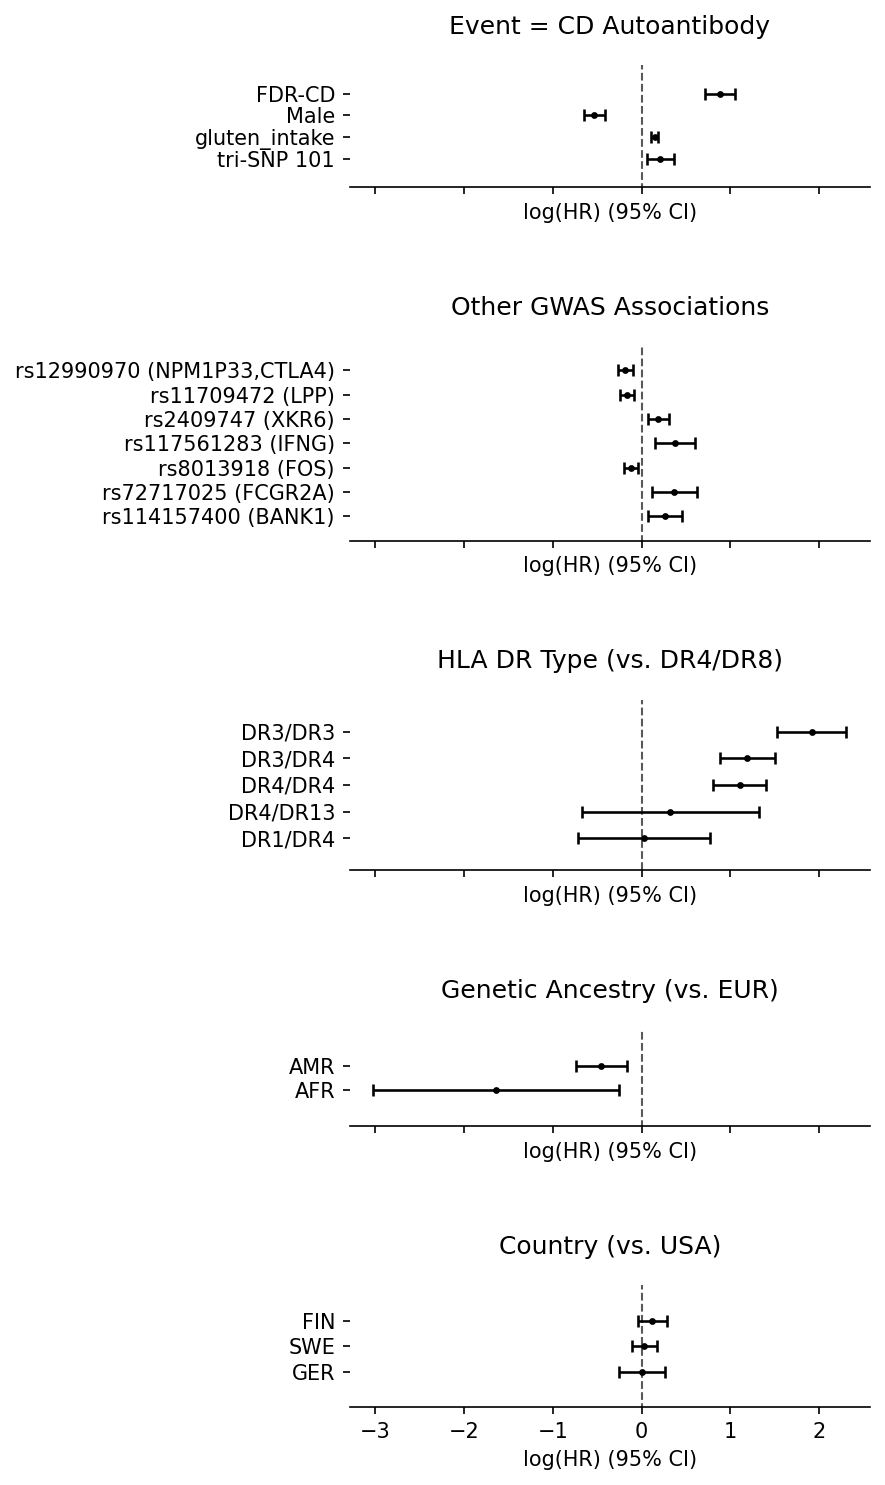

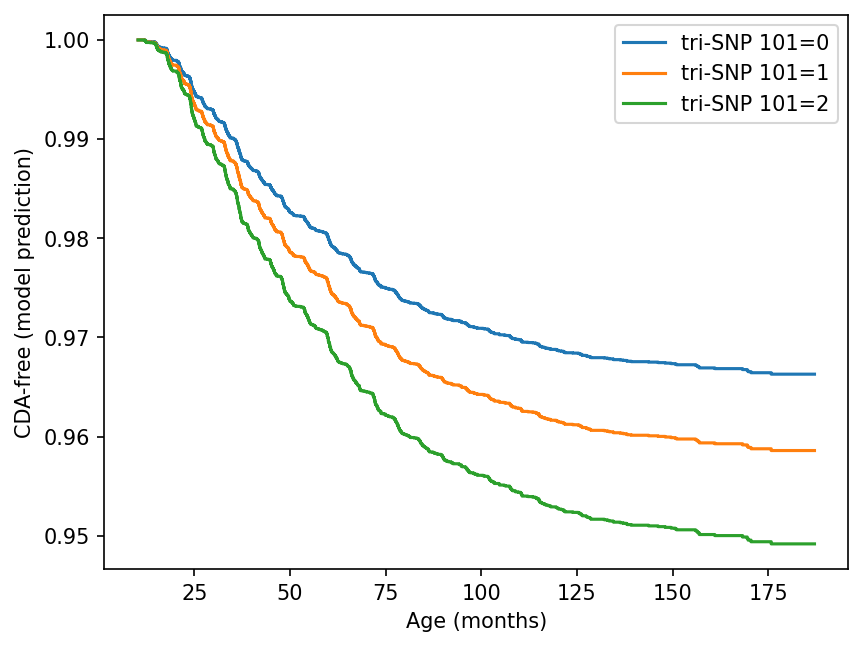

In [10]:
fit_var = "tri-SNP 101"

extension = "cox_cda_all_samples"
ylabel = "CDA-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for all samples

<lifelines.CoxPHFitter: fitted with 6557 total observations, 5275 right-censored observations>
             duration col = 'tga_persist_age_censor'
                event col = 'tga_persist'
          robust variance = True
      baseline estimation = breslow
   number of observations = 6557
number of events observed = 1282
   partial log-likelihood = -10548.37
         time fit was run = 2025-09-19 14:12:26 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
B8                           0.06       1.07       0.05            -0.03             0.16                 0.97                 1.18
FDR-CD                       0.89       2.42       0.09             0.72             1.05                 2.05                 2.87
gluten_intake                0.15       1.16       0.02             0.11             0.19                 1.11                 1.21
rs2409747 (XKR6)             0.18       1.20       0.06             0.07             0.30                 1.07                 1.35
rs12990970 (NPM1P33,CTLA4)  -0.18       0.83       0.04            -0.27            -0.10                 0.77                 0.90
rs11709472 (LPP)            -0.17       0.85       0.04            -0.24            -0.09                 0.78                 0.92
rs72717025 (FCGR2A)          0.37       1.44       0.13             0.11             0.62                 1.12                 1.85
rs114157400 (BANK1)          0.26       1.29       0.10             0.06             0.45                 1.06                 1.56
rs117561283 (IFNG)           0.38       1.46       0.11             0.16             0.61                 1.17                 1.83
rs8013918 (FOS)             -0.12       0.89       0.04            -0.20            -0.04                 0.82                 0.96
Male                        -0.53       0.59       0.06            -0.65            -0.41                 0.52                 0.66
AMR                         -0.49       0.61       0.15            -0.78            -0.21                 0.46                 0.81
AFR                         -1.79       0.17       0.70            -3.17            -0.41                 0.04                 0.66
DR3/DR3                      2.21       9.08       0.16             1.90             2.51                 6.67                12.35
DR3/DR4                      1.34       3.82       0.15             1.05             1.63                 2.87                 5.09
DR4/DR4                      1.11       3.04       0.15             0.81             1.41                 2.25                 4.09
DR1/DR4                      0.03       1.03       0.38            -0.71             0.77                 0.49                 2.15
DR4/DR13                     0.32       1.38       0.51            -0.67             1.32                 0.51                 3.74
SWE                          0.04       1.04       0.07            -0.11             0.18                 0.90                 1.20
FIN                          0.14       1.15       0.08            -0.02             0.30                 0.98                 1.34
GER                          0.02       1.02       0.13            -0.24             0.28                 0.78                 1.32

                               z      p   -log2(p)
covariate                                         
B8                          1.28   0.20       2.31
FDR-CD                     10.27 <0.005      79.73
gluten_intake               7.27 <0.005      41.32
rs2409747 (XKR6)            3.20 <0.005       9.49
rs12990970 (NPM1P33,CTLA4) -4.36 <0.005      16.23
rs11709472 (LPP)           -4.17 <0.005      14.99
rs72717025 (FCGR2A)         2.85 <0.005       7.83
rs114157400 (BANK1)         2.60   0.01       6.74
rs117561283 (IFNG)          3.33 

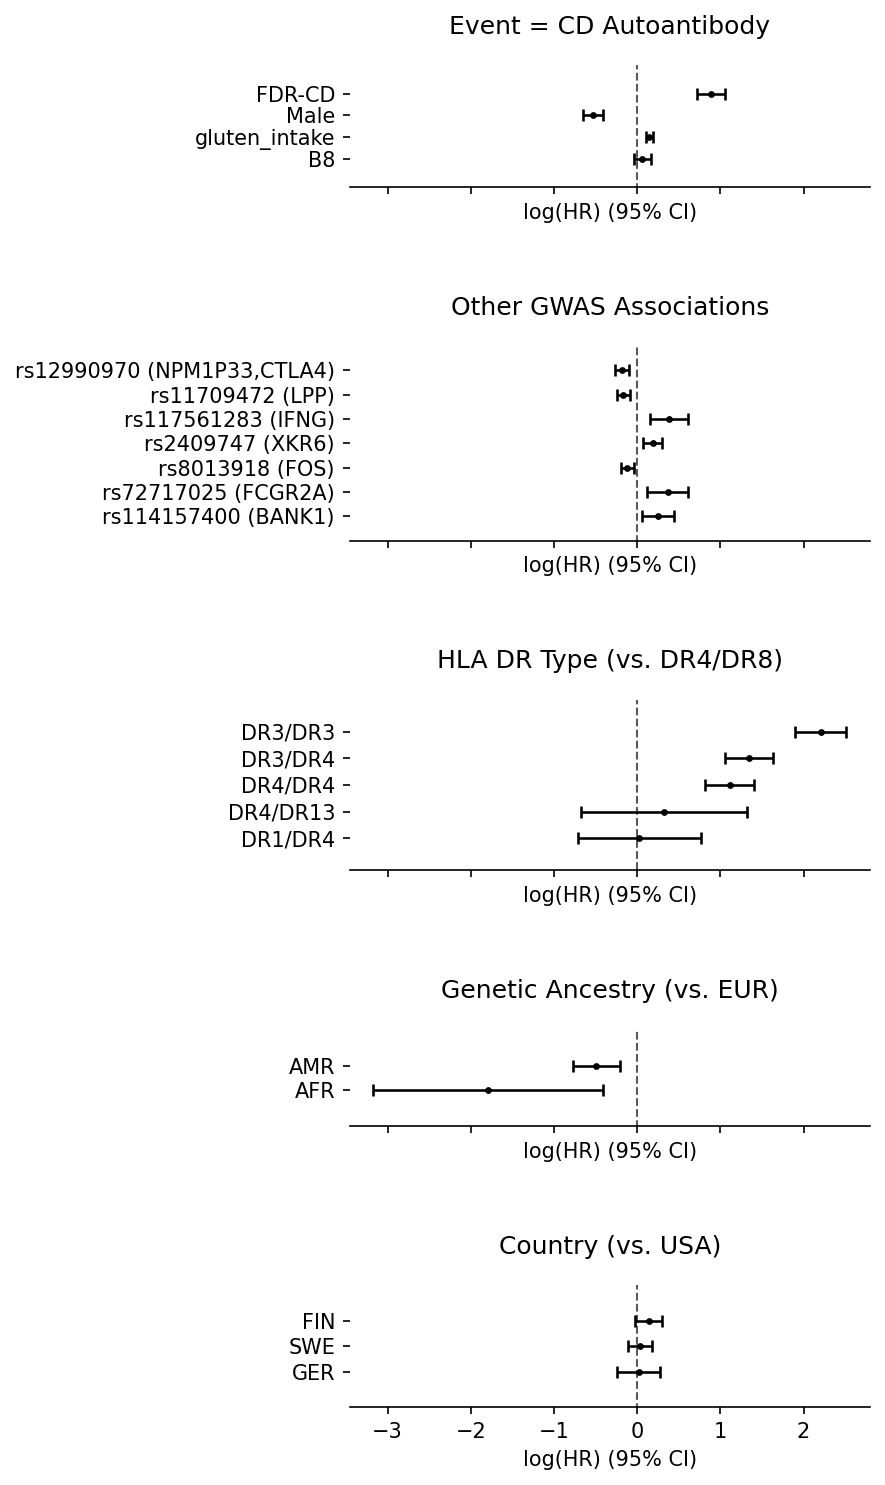

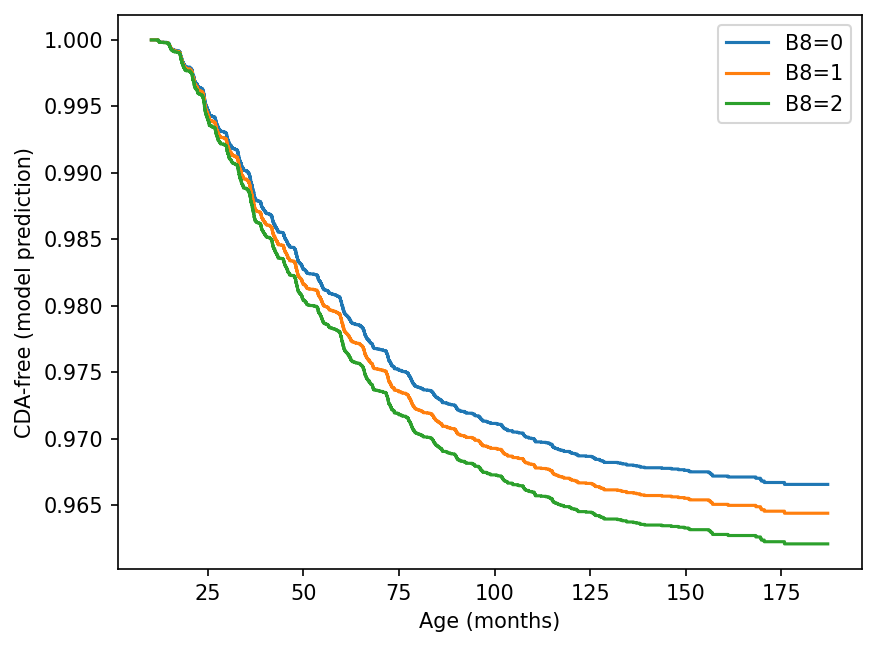

In [11]:
fit_var = "B8"

extension = "cox_cda_all_samples_b8"
ylabel = "CDA-free (model prediction)"

variables = [fit_var] + common_variables
data = filtered.loc[:, variables + outcomes].dropna()
dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_hla, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "HLA DR Type (vs. DR4/DR8)", 
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### DR3 homozygotes only

In [12]:
event = "Event = CD Autoantibody, DR3 Only"

common_variables = ['sex', 'FDR-CD', 'POP', 
                    "Country", "gluten_intake"] + assoc

### Fit trisnp
This creates supplementary figure 12.

<lifelines.CoxPHFitter: fitted with 1370 total observations, 844 right-censored observations>
             duration col = 'tga_persist_age_censor'
                event col = 'tga_persist'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1370
number of events observed = 526
   partial log-likelihood = -3538.97
         time fit was run = 2025-09-19 14:12:31 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
tri-SNP 101                  0.21       1.23       0.09             0.02             0.39                 1.02                 1.48
FDR-CD                       0.80       2.22       0.12             0.56             1.04                 1.74                 2.83
gluten_intake                0.14       1.15       0.03             0.07             0.21                 1.07                 1.23
rs2409747 (XKR6)             0.22       1.25       0.09             0.05             0.39                 1.05                 1.48
rs12990970 (NPM1P33,CTLA4)  -0.16       0.85       0.07            -0.29            -0.03                 0.75                 0.97
rs11709472 (LPP)            -0.17       0.84       0.06            -0.30            -0.05                 0.74                 0.96
rs72717025 (FCGR2A)          0.55       1.74       0.17             0.22             0.89                 1.24                 2.43
rs114157400 (BANK1)          0.50       1.64       0.15             0.20             0.79                 1.22                 2.21
rs117561283 (IFNG)           0.50       1.65       0.19             0.13             0.87                 1.14                 2.39
rs8013918 (FOS)             -0.17       0.84       0.06            -0.29            -0.05                 0.75                 0.95
Male                        -0.64       0.53       0.09            -0.82            -0.46                 0.44                 0.63
AMR                         -0.32       0.73       0.26            -0.84             0.20                 0.43                 1.22
AFR                         -0.97       0.38       0.72            -2.38             0.44                 0.09                 1.55
SWE                          0.27       1.31       0.11             0.05             0.48                 1.06                 1.61
FIN                          0.17       1.18       0.13            -0.08             0.42                 0.93                 1.52
GER                          0.10       1.11       0.21            -0.31             0.51                 0.73                 1.67

                               z      p   -log2(p)
covariate                                         
tri-SNP 101                 2.19   0.03       5.14
FDR-CD                      6.45 <0.005      33.05
gluten_intake               4.03 <0.005      14.16
rs2409747 (XKR6)            2.47   0.01       6.19
rs12990970 (NPM1P33,CTLA4) -2.36   0.02       5.78
rs11709472 (LPP)           -2.67   0.01       7.05
rs72717025 (FCGR2A)         3.22 <0.005       9.61
rs114157400 (BANK1)         3.26 <0.005       9.82
rs117561283 (IFNG)          2.63   0.01       6.87
rs8013918 (FOS)            -2.72   0.01       7.27
Male                       -6.97 <0.005      38.24
AMR                        -1.21   0.23       2.14
AFR                        -1.35   0.18       2.49
SWE                         2.46   0.01       6.16
FIN                         1.34   0.18       2.48
GER                         0.49   0.62       0.68
---
Concordance = 0.66
Partial AIC = 7109.95
log-likelihood ratio test = 173.34 on 16 df
-log2(p) of ll-ratio test = 92.16

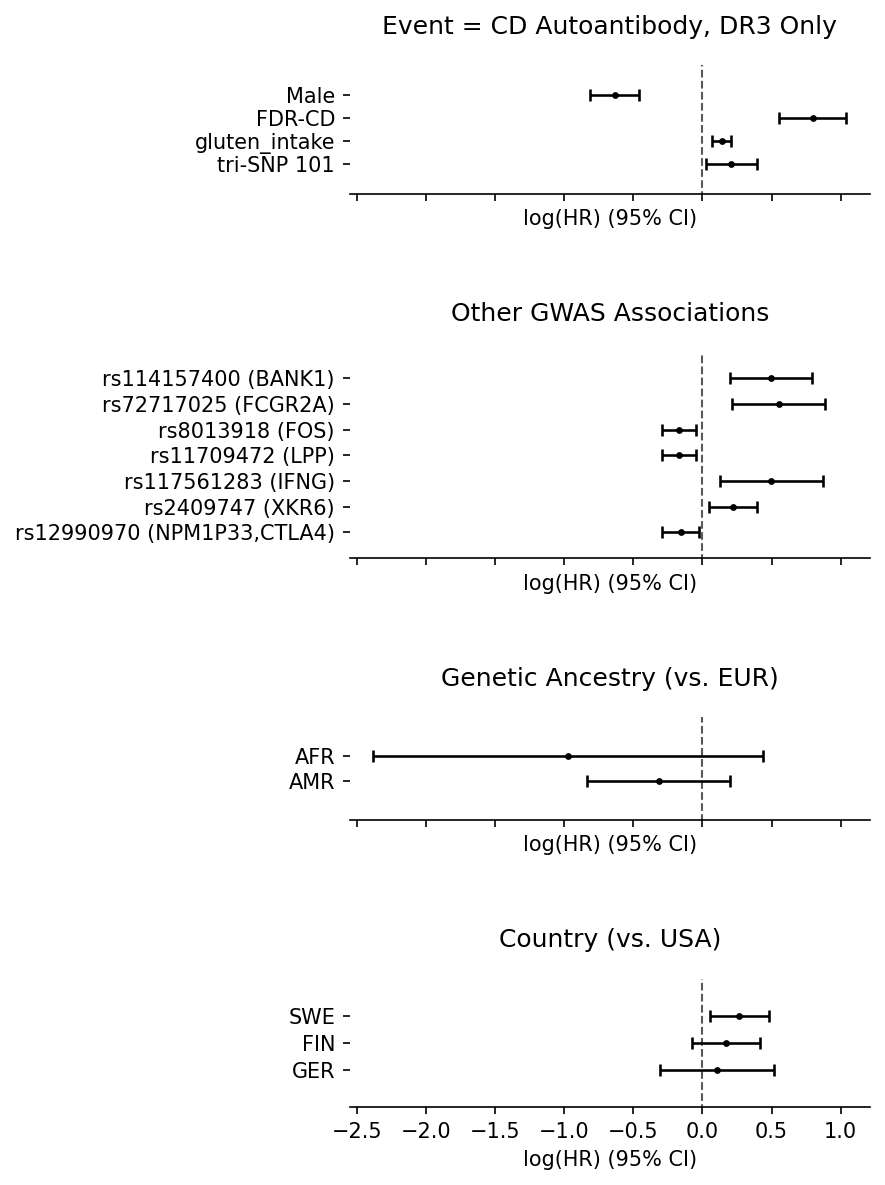

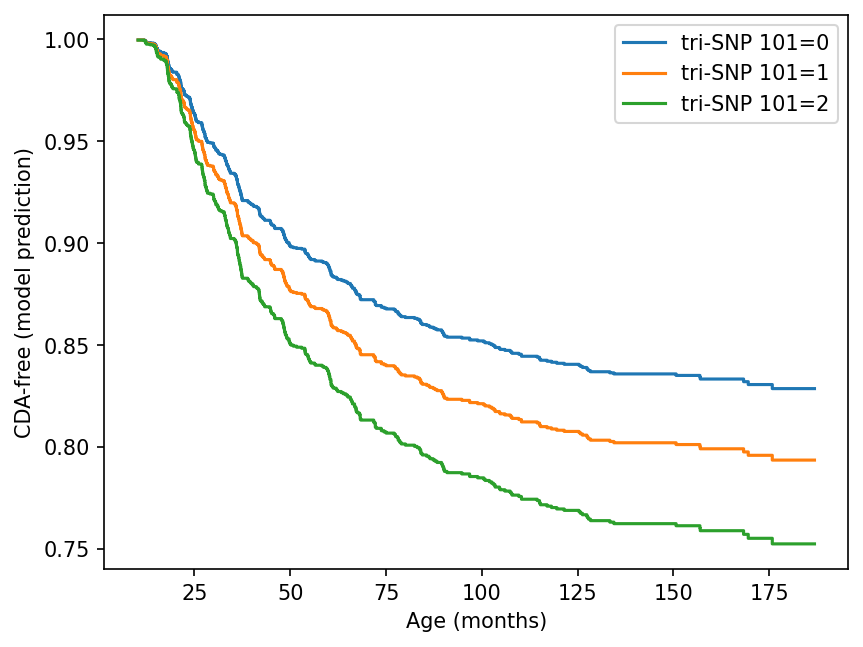

In [13]:
fit_var = "tri-SNP 101"

extension = "cox_cda_dr3_samples"
ylabel = "CDA-free (model prediction)"

variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)

### Fit B8 for DR3 homozygotes only

<lifelines.CoxPHFitter: fitted with 1370 total observations, 844 right-censored observations>
             duration col = 'tga_persist_age_censor'
                event col = 'tga_persist'
          robust variance = True
      baseline estimation = breslow
   number of observations = 1370
number of events observed = 526
   partial log-likelihood = -3540.15
         time fit was run = 2025-09-19 14:12:33 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
B8                           0.09       1.10       0.06            -0.03             0.21                 0.97                 1.24
FDR-CD                       0.80       2.21       0.12             0.55             1.04                 1.74                 2.82
gluten_intake                0.14       1.15       0.03             0.08             0.21                 1.08                 1.23
rs2409747 (XKR6)             0.21       1.23       0.09             0.04             0.38                 1.04                 1.46
rs12990970 (NPM1P33,CTLA4)  -0.16       0.85       0.07            -0.29            -0.03                 0.75                 0.97
rs11709472 (LPP)            -0.18       0.84       0.06            -0.30            -0.05                 0.74                 0.95
rs72717025 (FCGR2A)          0.55       1.74       0.17             0.22             0.88                 1.25                 2.42
rs114157400 (BANK1)          0.49       1.63       0.15             0.19             0.79                 1.21                 2.19
rs117561283 (IFNG)           0.53       1.70       0.19             0.16             0.90                 1.17                 2.46
rs8013918 (FOS)             -0.18       0.84       0.06            -0.30            -0.06                 0.74                 0.94
Male                        -0.64       0.53       0.09            -0.82            -0.46                 0.44                 0.63
AMR                         -0.40       0.67       0.26            -0.91             0.10                 0.40                 1.11
AFR                         -1.16       0.31       0.71            -2.55             0.23                 0.08                 1.26
SWE                          0.26       1.30       0.11             0.05             0.47                 1.05                 1.60
FIN                          0.18       1.19       0.13            -0.07             0.43                 0.93                 1.53
GER                          0.13       1.14       0.21            -0.28             0.53                 0.76                 1.71

                               z      p   -log2(p)
covariate                                         
B8                          1.53   0.13       2.98
FDR-CD                      6.41 <0.005      32.70
gluten_intake               4.18 <0.005      15.05
rs2409747 (XKR6)            2.38   0.02       5.87
rs12990970 (NPM1P33,CTLA4) -2.39   0.02       5.89
rs11709472 (LPP)           -2.76   0.01       7.43
rs72717025 (FCGR2A)         3.28 <0.005       9.93
rs114157400 (BANK1)         3.18 <0.005       9.42
rs117561283 (IFNG)          2.80   0.01       7.63
rs8013918 (FOS)            -2.90 <0.005       8.08
Male                       -6.99 <0.005      38.39
AMR                        -1.56   0.12       3.08
AFR                        -1.63   0.10       3.29
SWE                         2.38   0.02       5.85
FIN                         1.40   0.16       2.63
GER                         0.61   0.54       0.88
---
Concordance = 0.66
Partial AIC = 7112.30
log-likelihood ratio test = 170.99 on 16 df
-log2(p) of ll-ratio test = 90.60

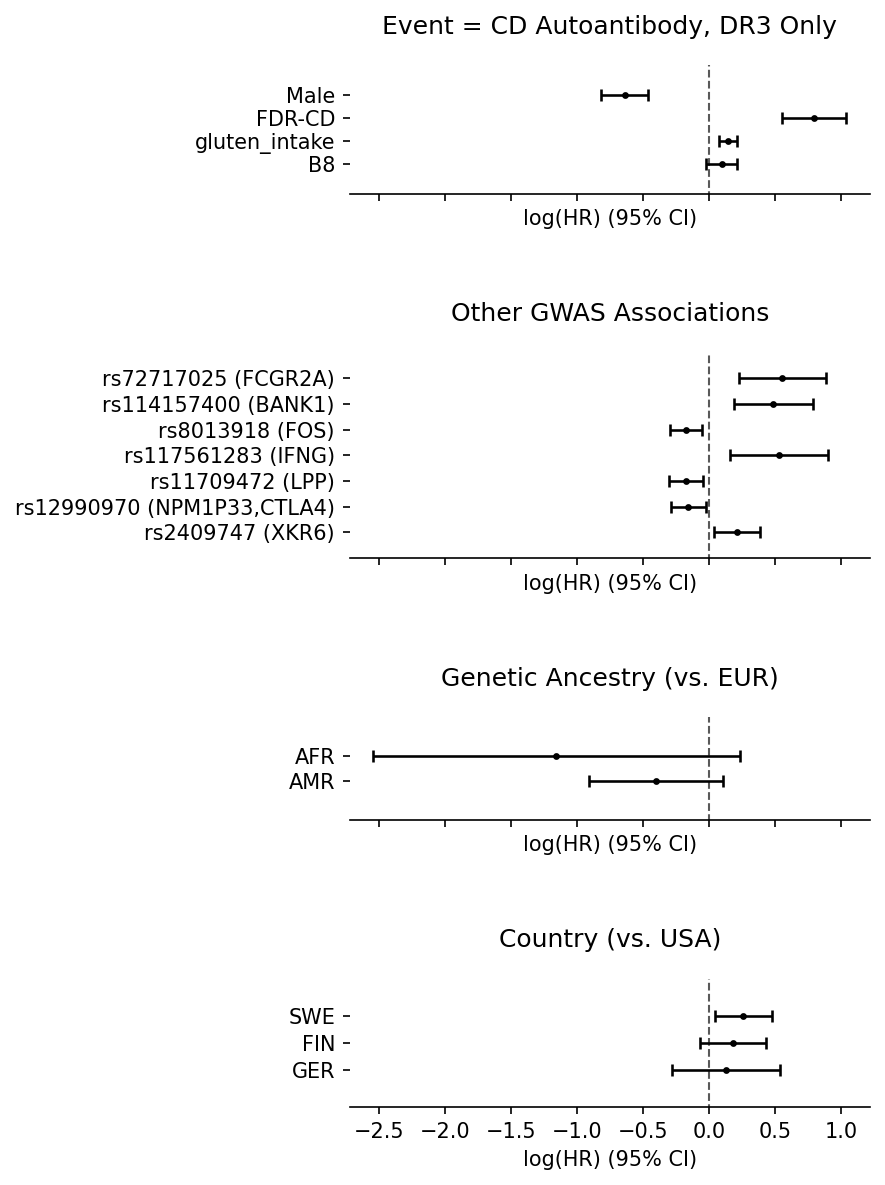

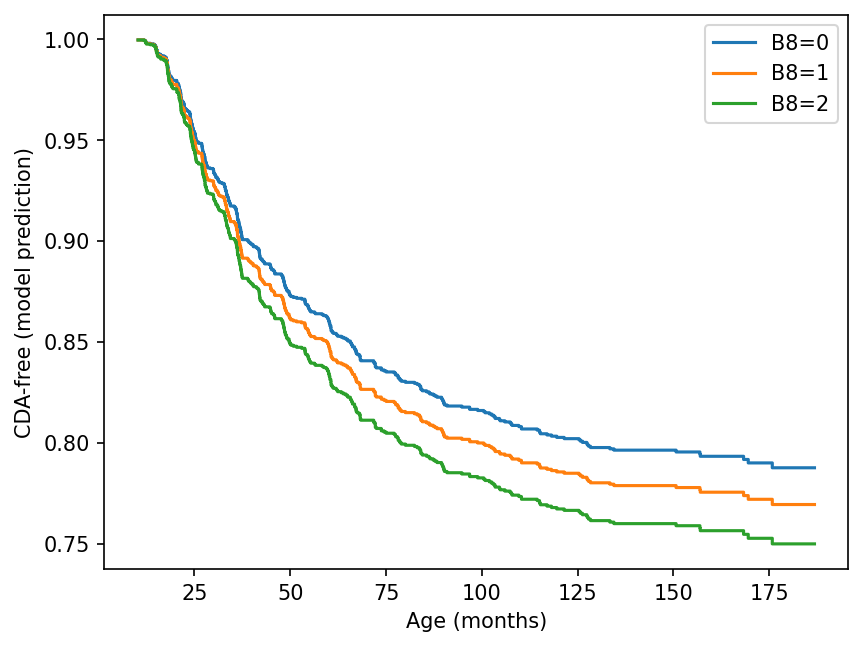

In [14]:
fit_var = "B8"

extension = "cox_cda_dr3_samples_b8"
ylabel = "CDA-free (model prediction)"


variables = [fit_var] + common_variables

data = filtered.loc[filtered["hla_type"] == "DR3/DR3",
                    variables + outcomes].dropna()

dummy = pd.get_dummies(data, drop_first=True, prefix="", prefix_sep="")
cph = CoxPHFitter()
cph.fit(dummy, time, event_col=outcome, robust=True)
cph.print_summary()

summary = cph.summary.reset_index()
summary.to_csv(extension + "_summary.csv")

others = [fit_var] + common_others

covar_list = [others, assoc, select_pops, ctry]
titles = [event, "Other GWAS Associations",
          "Genetic Ancestry (vs. EUR)",
          "Country (vs. USA)"]
fig, axes = plt.subplots(
    len(covar_list), 1, sharex=True, gridspec_kw={
        'height_ratios': [len(cov) + 1 for cov in covar_list]})

for i in range(len(covar_list)):
    ax = axes[i]
    covars = list(summary.loc[summary["covariate"].isin(
        covar_list[i])].sort_values("p")["covariate"].values)
    cph.plot(ax=ax, columns=covars, hazard_ratios=False, ms=2, fmt="o", markerfacecolor="k")
    ax.set_title(titles[i], pad=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.autoscale(True, axis="y")
    ax.margins(y=-0.1)

fig.set_dpi(150)
fig.set_size_inches(6, 2 * len(covar_list))
fig.tight_layout(h_pad=3.5)
fig.savefig(extension + ".pdf")
fig.savefig(extension + ".png", facecolor="w")

fig, ax = plt.subplots()
cph.plot_partial_effects_on_outcome(covariates=fit_var, values=[0,1,2], 
                                    plot_baseline=False, ax=ax)
ax.set_xlabel("Age (months)")
ax.set_ylabel(ylabel)
fig.set_dpi(150)
fig.savefig(extension + "_effect_on_outcome.pdf")
fig.savefig(extension + "_effect_on_outcome.png", facecolor="w")

with open(extension + "_cph.pickle", "wb") as outfile:
    pickle.dump(cph, outfile)